# A3 Practice - Software development

In this notebook, we try to display a multiband tif in a folium map.

In [1]:
#import necessary libraries
import rasterio
import folium
import numpy as np
import matplotlib.pyplot as plt


## Metadata about our tif file

We open the sample file to display the metadata and get to know our image

In [2]:
raster = 'sample.tif'

# Open the TIF file using rasterio and print details 
with rasterio.open(raster) as src:
    print('TIFF File:', raster)
    print('Driver:', src.driver)
    print('Dimensions:', src.width, 'x', src.height)
    print('Number of Bands:', src.count)
    print('Data Type:', src.dtypes[0])
    print('Coordinate Reference System (CRS):', src.crs)
    print('Bounds:', src.bounds)


TIFF File: sample.tif
Driver: GTiff
Dimensions: 1001 x 1001
Number of Bands: 3
Data Type: uint16
Coordinate Reference System (CRS): EPSG:32631
Bounds: BoundingBox(left=590520.0, bottom=5780620.0, right=600530.0, top=5790630.0)


## Visualizing bands

Text(0.5, 1.0, 'Blue Channel')

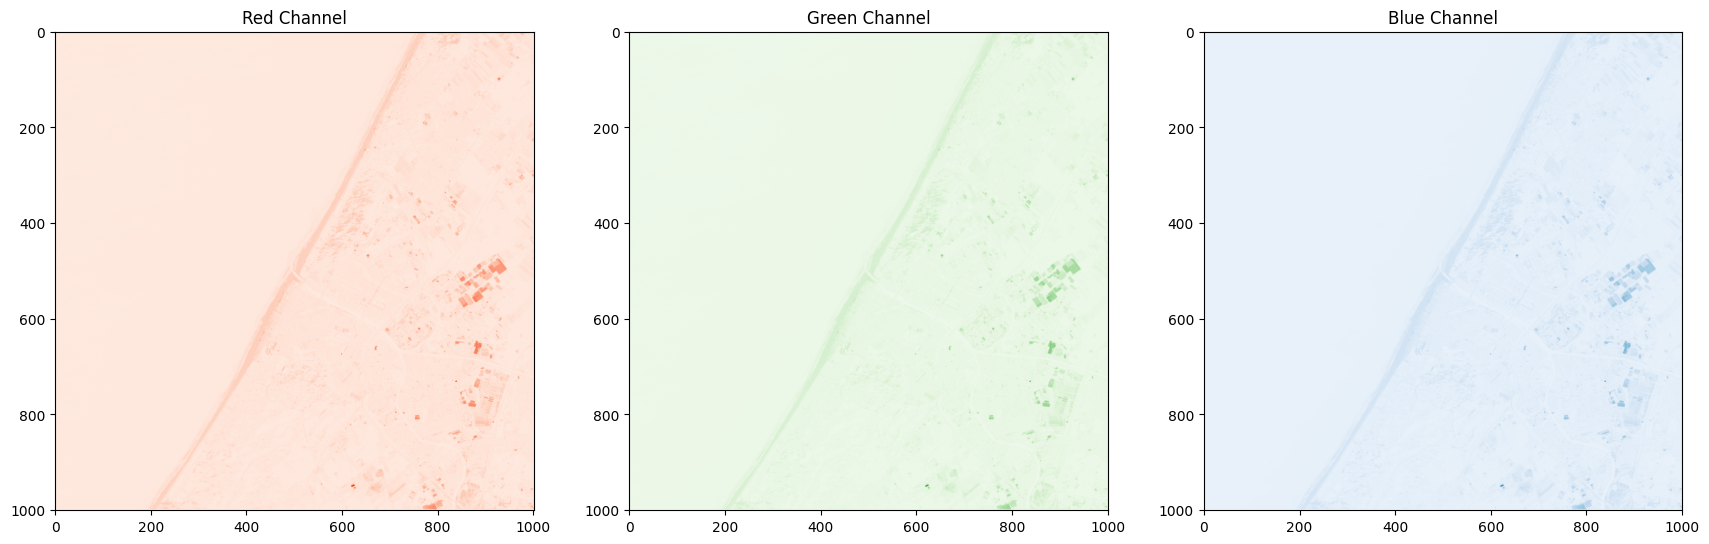

In [3]:
# Open the TIF file using rasterio and read the individual bands
with rasterio.open(raster) as src:
    band1 = src.read(1)
    band2 = src.read(2)
    band3 = src.read(3)
#Plot bands in separate plots
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))

axr.imshow(band1, cmap='Reds')
axr.set_title('Red Channel')
axg.imshow(band1, cmap='Greens')
axg.set_title('Green Channel')
axb.imshow(band1, cmap='Blues')
axb.set_title('Blue Channel')

## Overlaying the image on a folium map 

To correctly overlay our image in the folium map, we need to [transform](https://rasterio.readthedocs.io/en/stable/topics/reproject.html) the image's coordinates.

image center coordinates [52.212751208053774, 4.398214069761309]



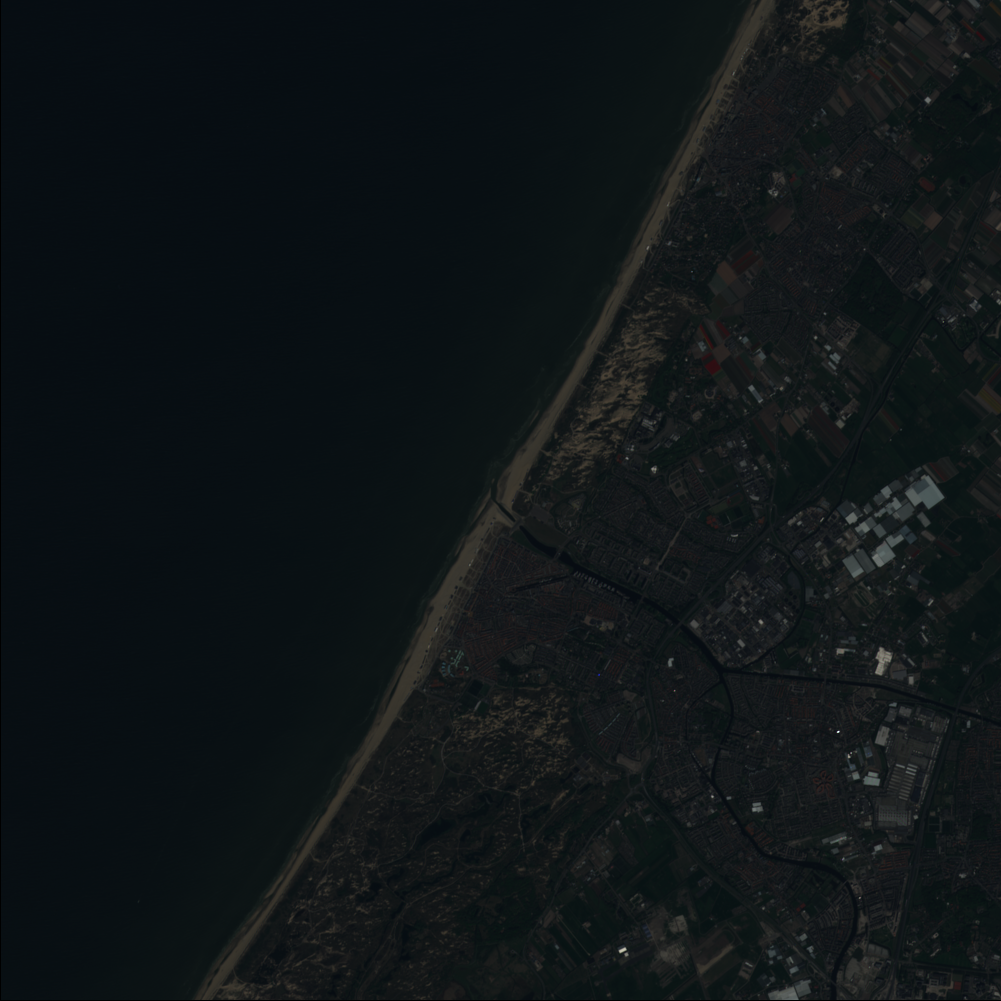

In [4]:
#importing this library to transform coordinates
from rasterio.warp import transform_bounds

# Open the TIF file using rasterio and read the individual bands
with rasterio.open(raster) as src:
    # Read the bands
    band1 = src.read(1)
    band2 = src.read(2)
    band3 = src.read(3)

    # Read the image extent
    extent = src.bounds
    #stack all bands
    composite_image = np.dstack((band3, band2, band1))

    # Define the target CRS
    target_crs = 'EPSG:4326'
    
    # Transform the image extent to the target CRS
    transformed_extent = transform_bounds(src.crs, target_crs, *src.bounds)
    image_center = [(transformed_extent[1] + transformed_extent[3]) / 2, (transformed_extent[0] + transformed_extent[2]) / 2]

print("image center coordinates",image_center)

# Create a Folium map centered on the transformed image extent
m = folium.Map(location=[image_center[0], image_center[1]], zoom_start=12)

# Create an overlay with the image and add it to the map
image_overlay = folium.raster_layers.ImageOverlay(
    image=composite_image,
    bounds=[[transformed_extent[1], transformed_extent[0]], [transformed_extent[3], transformed_extent[2]]],
)
image_overlay.add_to(m)

# Display the map
m


This assignment looks simple but it took me longer than expected to get to know the basics of dealing with multiband geotiff, projections, coordinates calculations... <br>
There's always more to learn and improve and one great example of this is the bands stacking and displayed colors (the image is dark on the map, maybe it needs min max values adjustment, maybe there's something else) so any suggestions in this or any other direction are welcome.

# Further work after submission

I tried to explore more the pixel values to understand how to display the image better. 

value of max pixel R 10964
value of max pixel G 10349
value of max pixel B 11652


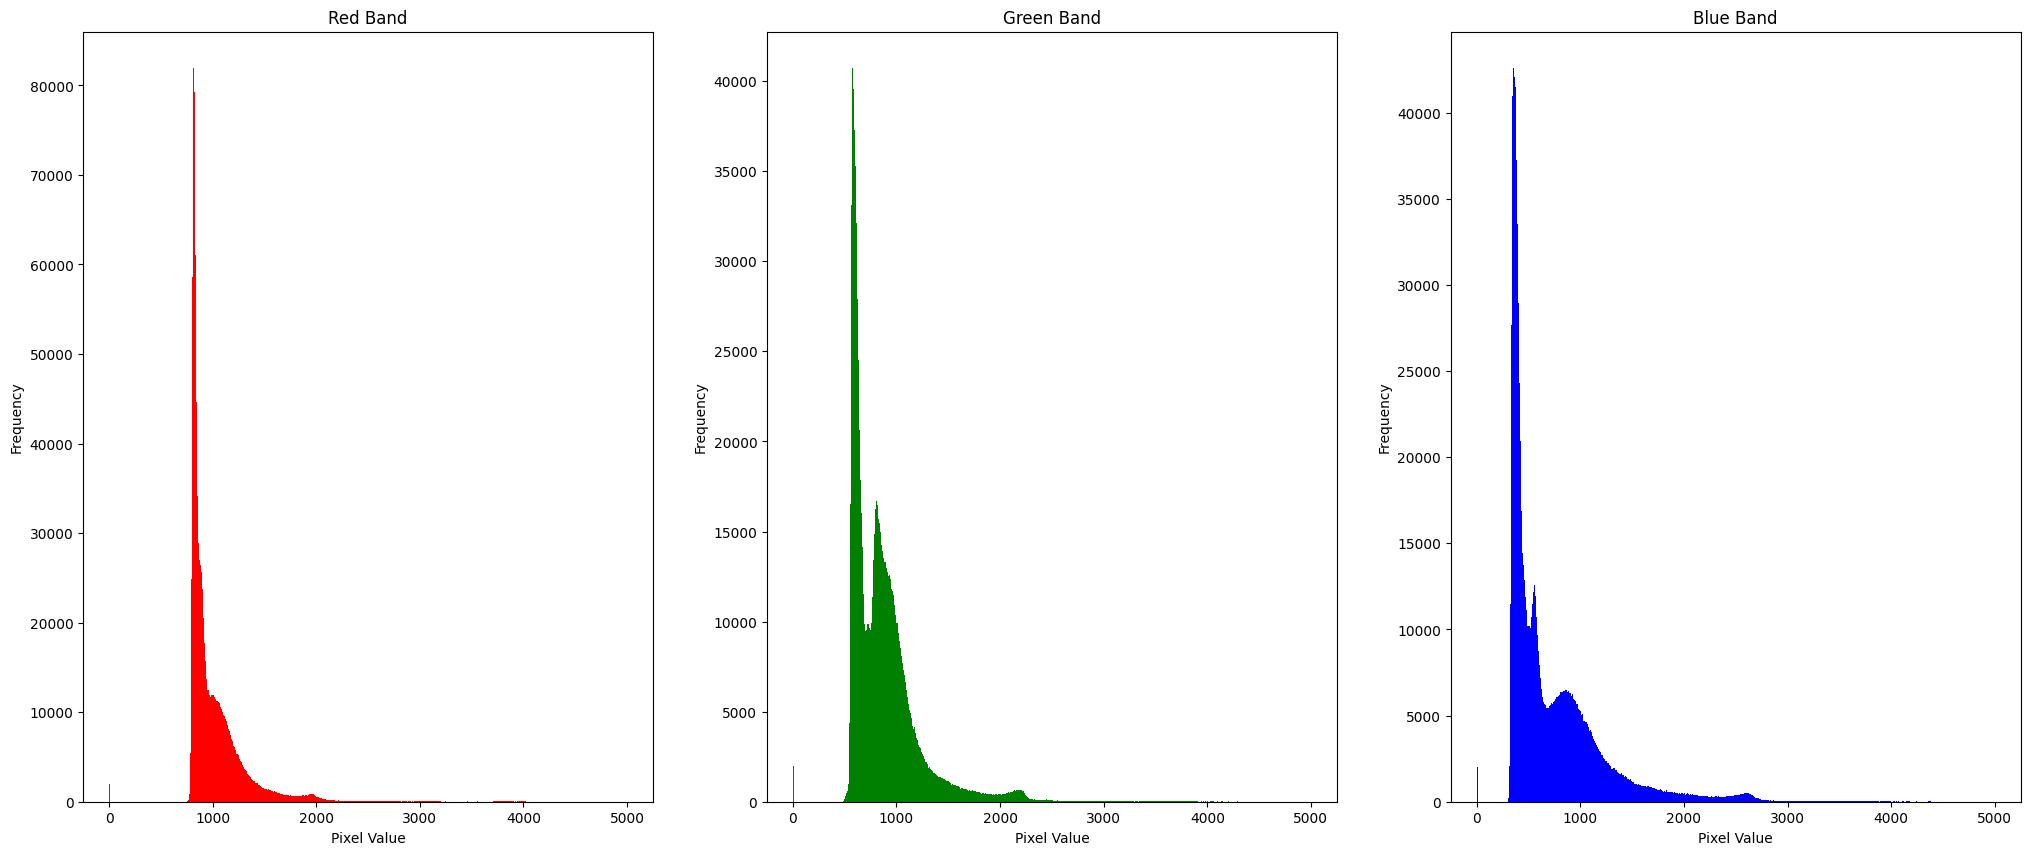

In [5]:
pixel_values1 = band1.flatten()
pixel_values2 = band2.flatten()
pixel_values3 = band3.flatten()


print('value of max pixel R', max(pixel_values1))
print('value of max pixel G', max(pixel_values2))
print('value of max pixel B', max(pixel_values3))

fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(25,10))

# Plot histogram for Band 1 (Red)
axr.hist(pixel_values1, bins=500, range=[0, 5000], color='red')
axr.set_xlabel('Pixel Value')
axr.set_ylabel('Frequency')
axr.set_title('Red Band')

# Plot histogram for Band 2 (Green)
axg.hist(pixel_values2, bins=500, range=[0, 5000], color='green')
axg.set_xlabel('Pixel Value')
axg.set_ylabel('Frequency')
axg.set_title('Green Band')

# Plot histogram for Band 3 (Blue)
axb.hist(pixel_values3, bins=500, range=[0, 5000], color='blue')
axb.set_xlabel('Pixel Value')
axb.set_ylabel('Frequency')
axb.set_title('Blue Band')

plt.show()

After trying to display the image in ArcGIS, I thought about trying to implement a Percent Clip stretch type. 


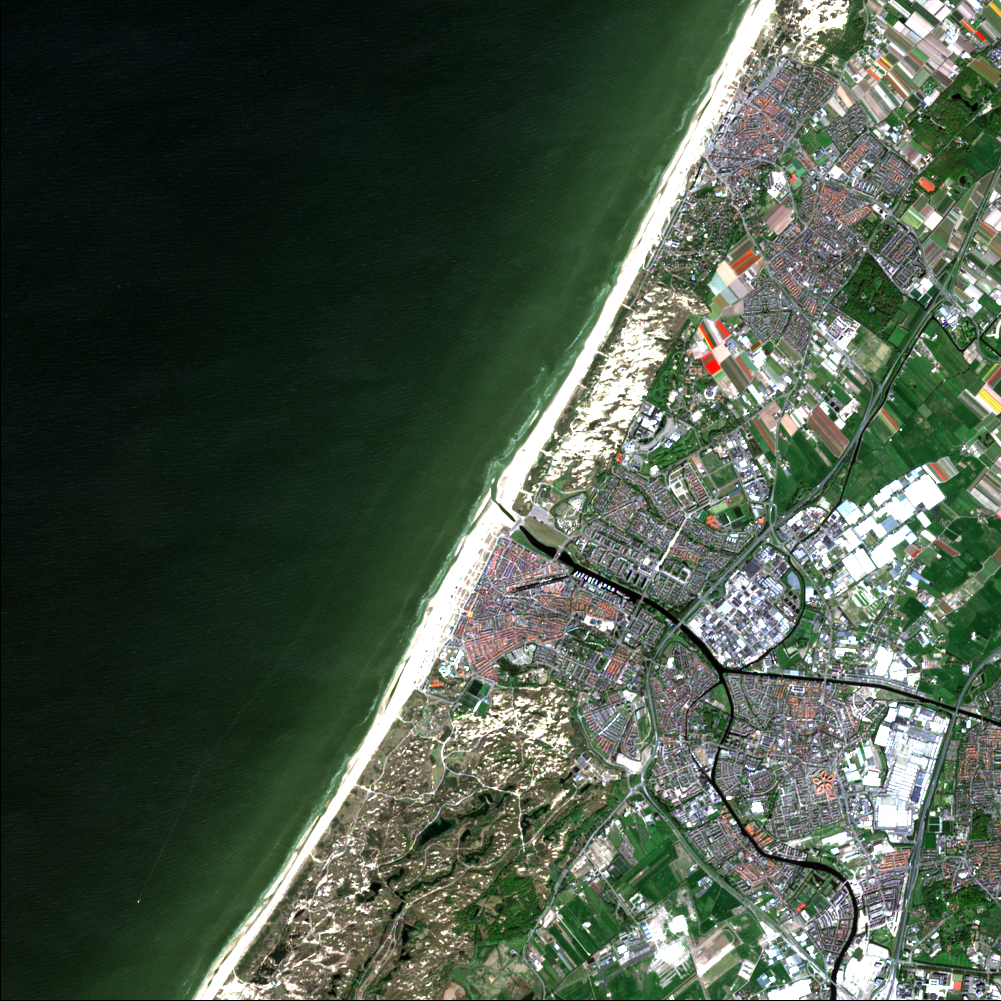

In [6]:

# Define the percentile values for clipping
clip_min_percentile = 0.25  # Minimum percentile to clip
clip_max_percentile = 95  # Maximum percentile to clip

# Calculate the percentile values for each band
red_min_val = np.percentile(band1, clip_min_percentile)
red_max_val = np.percentile(band1, clip_max_percentile)
green_min_val = np.percentile(band2, clip_min_percentile)
green_max_val = np.percentile(band2, clip_max_percentile)
blue_min_val = np.percentile(band3, clip_min_percentile)
blue_max_val = np.percentile(band3, clip_max_percentile)

# Clip the pixel values within the defined percentiles
red_band_clipped = np.clip(band1, red_min_val, red_max_val)
green_band_clipped = np.clip(band2, green_min_val, green_max_val)
blue_band_clipped = np.clip(band3, blue_min_val, blue_max_val)

# Normalize the clipped pixel values to the range of 0-1
red_band_norm = (red_band_clipped - red_min_val) / (red_max_val - red_min_val)
green_band_norm = (green_band_clipped - green_min_val) / (green_max_val - green_min_val)
blue_band_norm = (blue_band_clipped - blue_min_val) / (blue_max_val - blue_min_val)

# Stack the normalized RGB bands together to create a true color image
true_color_image = np.dstack((blue_band_norm, green_band_norm, red_band_norm))

# Create a Folium map centered on the transformed image extent
m = folium.Map(location=[image_center[0], image_center[1]], zoom_start=12)

# Create an overlay with the image and add it to the map
image_overlay = folium.raster_layers.ImageOverlay(
    image=true_color_image,
    bounds=[[transformed_extent[1], transformed_extent[0]], [transformed_extent[3], transformed_extent[2]]],
)
image_overlay.add_to(m)

# Display the map
m